In [11]:
import pandas as pd
import gurobipy 
from gurobipy import Model, GRB, quicksum
import numpy as np

# Loading the dataset 
brick_index_value = pd.read_csv('./bricks_index_values.csv')
brick_rp_distances = pd.read_csv('./brick_rp_distances.csv')
#distances= pd.read_csv('./distances.xlsx')
pfizer =pd.read_csv('./Pfitzer10-100.csv', sep=';')

### 1. Objectif de minimisation de la distance

In [12]:
# Extracting data from the datasets
bricks = brick_index_value['brick'].tolist()
reps = list(range(1, 5))  # 4 représentants

# Converting distance to a dictionary f
distances = {
    row['brick']: [row[f'rp{i}'] for i in reps]
    for _, row in brick_rp_distances.iterrows()
}

# Converting index values to a dictionary
index_values = dict(zip(brick_index_value['brick'], brick_index_value['index_value']))

# Workload interval bounds
L = 0.8 
U = 1.2

# Modèle pour minimiser la distance
model_distance = Model("Minimize_Distance")

# Variables de décision 
# Variables binaires x[b, r], chaques briques b est assignée à un représentant r
x = model_distance.addVars(bricks, reps, vtype=GRB.BINARY, name="x") 

# Fonction objectif : minimiser la distance totale
model_distance.setObjective(
    quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

# Fonction objectif : minimiser la distance totale
# Chaque brique est assignée à un seul représentant
model_distance.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

# Contraintes de charge de travail dans l'intervalle [L, U]
model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)

model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

# Optimisation
model_distance.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x4ea169f8
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]


  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 353.0700000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.488198e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.81982    0    6  353.07000  148.81982  57.8%     -    0s
H    0     0                     180.9600000  148.81982  17.8%     -    0s
H    0     0                     154.6200000  148.81982  3.75%     -    0s
     0     0  148.81982    0    6  154.62000  148.81982  3.75%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 154.62 180.96 353.07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1

In [22]:
# Affichage des résultats sous forme de tableau
if model_distance.Status == GRB.OPTIMAL:
    print("\nDistance totale minimale :", model_distance.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(
        results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]



Distance totale minimale : 154.62


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,3
9,10,2


### 2. Objectif minimisation de disruption

In [14]:
# Assignation initiale des briques aux représentants
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}

# Modèle pour minimiser la perturbation
model_disruption = Model("Minimize_Disruption")

# Variables de décision
x = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
y = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

# Fonction objectif : minimiser la perturbation pondérée par l'index
model_disruption.setObjective(
    quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

# Contraintes
# 1. Chaque brick doit être attribué à un seul représentant
model_disruption.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

# Charge de travail dans l'intervalle [L, U]
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

# 3. Mesurer la perturbation
model_disruption.addConstrs(
    (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
     for b in bricks for r in reps), name="Disruption"
)

# Résoudre le modèle
model_disruption.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 118 rows, 176 columns and 440 nonzeros
Model fingerprint: 0xa736d90c
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 2.6088000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 25 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [23]:
# Afficher les résultats sous forme de tableau
if model_disruption.Status == GRB.OPTIMAL:
    print("\nPerturbation totale minimale :", model_disruption.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]


Perturbation totale minimale : 0.1696


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,3
9,10,2


### 3. epsilon constraint


Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x00392e93
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 1.8370000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

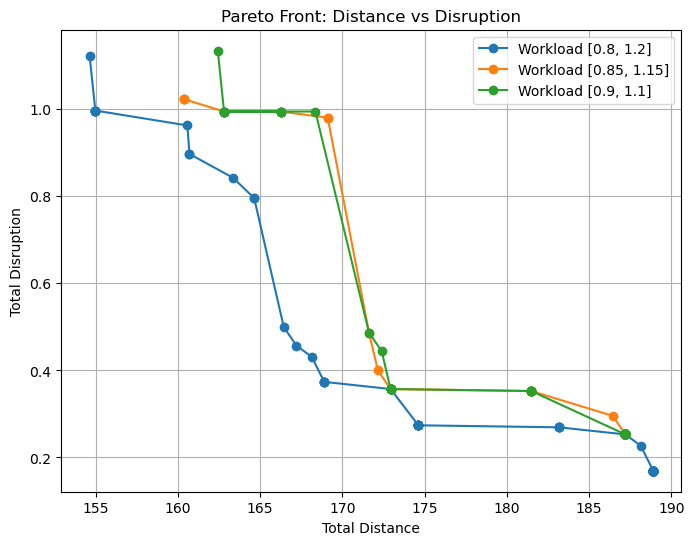

In [33]:
# Function implementing the epsilon-constraint scheme
# Workload bounds to test
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

def epsilon_constraint_scheme(initial_assignment, max_distance, workload_bounds):
    pareto_solutions = []
    epsilon = max_distance  # Initial upper bound for distance
    epsilon_step = 1  # Step to decrease epsilon

    # Iterate over different workload constraints
    for L, U in workload_bounds:
        print(f"\nSolving for workload constraints: [{L}, {U}]")
        epsilon = max_distance  # Reset epsilon for each workload bound

        # Start epsilon-constraint loop
        while epsilon >= 0:
            # Define model
            model = Model("Epsilon_Constraint")

            # Decision variables
            x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
            y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

            # Objectives
            total_distance = quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps)
            total_disruption = quicksum(index_values[b] * y[b, r] for b in bricks for r in reps)

            # Objective: minimize disruption
            model.setObjective(total_disruption, GRB.MINIMIZE)

            # Constraints
            model.addConstrs((quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick")
            model.addConstr(total_distance <= epsilon, name="Epsilon_Distance")
            model.addConstrs((y[b, r] >= x[b, r] - (1 if initial_assignment.get(b, None) == r else 0)
                              for b in bricks for r in reps), name="Disruption")
            model.addConstrs((quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload")
            model.addConstrs((quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload")

            # Optimize the model
            model.optimize()

            # Check feasibility and store solutions
            if model.Status == GRB.OPTIMAL:
                solution_distance = total_distance.getValue()
                solution_disruption = total_disruption.getValue()
                pareto_solutions.append((L, U, solution_distance, solution_disruption))
                print(f"Solution found: Distance = {solution_distance}, Disruption = {solution_disruption}")
            else:
                print(f"No feasible solution for epsilon: {epsilon} and workload [{L}, {U}]")

            # Reduce epsilon
            epsilon -= epsilon_step

    return pareto_solutions

# Compute Pareto solutions
max_distance = sum(distances[b][0] for b in bricks)  # Initial large distance
pareto_solutions = epsilon_constraint_scheme(initial_assignment, max_distance, workload_bounds)

# Plot the set of non-dominated solutions
def plot_pareto_solutions(pareto_solutions):
    plt.figure(figsize=(8, 6))
    for L, U in set((L, U) for L, U, _, _ in pareto_solutions):
        subset = [(d, dis) for (lb, ub, d, dis) in pareto_solutions if lb == L and ub == U]
        distances, disruptions = zip(*subset)
        plt.plot(distances, disruptions, marker='o', linestyle='-', label=f"Workload [{L}, {U}]")
    plt.xlabel("Total Distance")
    plt.ylabel("Total Disruption")
    plt.title("Pareto Front: Distance vs Disruption")
    plt.legend()
    plt.grid(True)
    plt.show()

# Print the set of non-dominated solutions
print("\nSet of Non-Dominated Solutions:")
for L, U, distance, disruption in pareto_solutions:
    print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

# Plot the Pareto front
plot_pareto_solutions(pareto_solutions)